In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import numpy as np


In [2]:
df = pd.read_csv("../AAPL_data.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[23:]
df

,Close,High,Low,Open,Volume
Date,,,,,
2014-01-06,16.929031,17.018355,16.607525,16.727351,412610800
2014-01-07,16.807955,16.992205,16.741973,16.941163,317209200
2014-01-08,16.914400,16.979759,16.765941,16.769674,258529600
2014-01-09,16.698412,17.020229,16.661997,17.018361,279148800
2014-01-10,16.586985,16.831616,16.530028,16.801425,304976000
...,...,...,...,...,...
2023-12-22,192.444580,194.243775,191.818335,194.015137,37122800
2023-12-26,191.897888,192.732871,191.679200,192.454544,28919300
2023-12-27,191.997253,192.345171,189.949550,191.341204,48087700


In [3]:
from sklearn.preprocessing import MinMaxScaler

def preprocess(data_trend, train_ratio, n_past, predict_day):
    scaler = MinMaxScaler()  
    print(data_trend.shape)
    data_trend = scaler.fit_transform(data_trend)
    
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day, 0])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data = df[[c for c in df.columns if c not in ['Date','Volume']]].values
train_ratio = 0.9
test_val_ratio = 0.9
n_past = 40     #移動視窗大小
predict_day = 10 #要預測後面幾天
X_train, Y_train, X_val, Y_val, X_test, Y_test, scaler = preprocess(data, train_ratio, n_past, predict_day)
batch_size = 32

train_set = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=False)

val_set = torch.utils.data.TensorDataset(X_val, Y_val)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

test_set = torch.utils.data.TensorDataset(X_test, Y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)




(2514, 4)


In [4]:
class GRU(nn.Module):
    def __init__(self, n_features, hidden_dim, predict_day):
        super(GRU, self).__init__()
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.predict_day = predict_day
        
        # GRU layer
        self.gru = nn.GRU(input_size=self.n_features, hidden_size=self.hidden_dim, 
                          num_layers=2, bidirectional=False, batch_first=True, dropout=0.2)
        
        # Fully connected output layer
        self.linear = nn.Linear(self.hidden_dim, self.predict_day)
        
    def forward(self, x): 
        # GRU forward pass
        x, _ = self.gru(x)
        
        # Pass the last time step's output to the linear layer
        x = self.linear(x[:, -1, :])  # (batch_size, predict_day)
        
        return x


In [7]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
# 檢查是否有可用的GPU
if torch.cuda.is_available():
    print("GPU")
    device = torch.device("cuda")  # 使用GPU
else:
    print("CPU")
    device = torch.device("cpu")  # 使用CPU
# 設置訓練參數
num_epochs = 100
learning_rate = 0.001

# 初始化模型、損失函數和優化器
model = GRU(n_features=4, hidden_dim=128, predict_day=10)
model = model.to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

GPU


In [8]:
# 記錄每個 epoch 的損失值
train_losses = []
val_losses = []
min_val_loss = float('inf')
best_model_path = "gru_10.pth"

# 訓練模型
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for i, (x_batch, y_batch) in enumerate(train_loader):
        x_batch= x_batch.to(device)
        y_batch= y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    # 驗證模型
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for i, (x_batch, y_batch) in enumerate(test_loader):
            x_batch= x_batch.to(device)
            y_batch= y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    
    # 打印每個epoch的訓練和驗證損失
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    torch.save(model, best_model_path)



Epoch [1/100], Train Loss: 0.0031, Val Loss: 0.0042
Epoch [2/100], Train Loss: 0.0160, Val Loss: 0.0104
Epoch [3/100], Train Loss: 0.0295, Val Loss: 0.0069
Epoch [4/100], Train Loss: 0.0269, Val Loss: 0.0153
Epoch [5/100], Train Loss: 0.0102, Val Loss: 0.0046
Epoch [6/100], Train Loss: 0.0033, Val Loss: 0.0030
Epoch [7/100], Train Loss: 0.0011, Val Loss: 0.0018
Epoch [8/100], Train Loss: 0.0013, Val Loss: 0.0013
Epoch [9/100], Train Loss: 0.0012, Val Loss: 0.0017
Epoch [10/100], Train Loss: 0.0010, Val Loss: 0.0011
Epoch [11/100], Train Loss: 0.0008, Val Loss: 0.0015
Epoch [12/100], Train Loss: 0.0008, Val Loss: 0.0012
Epoch [13/100], Train Loss: 0.0006, Val Loss: 0.0013
Epoch [14/100], Train Loss: 0.0006, Val Loss: 0.0010
Epoch [15/100], Train Loss: 0.0006, Val Loss: 0.0012
Epoch [16/100], Train Loss: 0.0006, Val Loss: 0.0010
Epoch [17/100], Train Loss: 0.0007, Val Loss: 0.0012
Epoch [18/100], Train Loss: 0.0006, Val Loss: 0.0013
Epoch [19/100], Train Loss: 0.0011, Val Loss: 0.0015
Ep

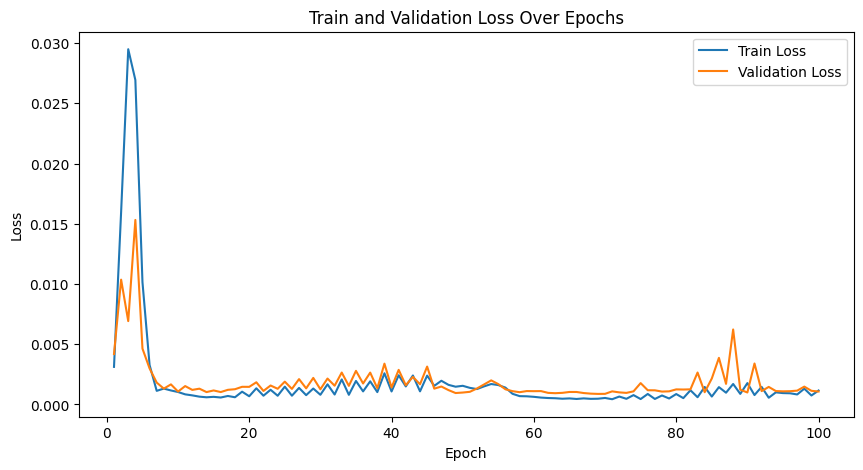

In [9]:
import matplotlib.pyplot as plt
# 繪製損失走勢圖
plt.figure(figsize=(10, 5))
plt.plot(range(1, 100+1), train_losses, label='Train Loss')
plt.plot(range(1, 100+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train and Validation Loss Over Epochs')
plt.show()

In [10]:
import matplotlib.pyplot as plt
print(len(Y_test))
close_price_true = []
temp_real = []
real = Y_test.detach().cpu().numpy()
for i in range(len(Y_test)):
   temp_real.append(real[i][0])
temp_real = np.array(temp_real)
print(temp_real.shape)
temp_real = temp_real.reshape(-1, 1)
temp_real = np.repeat(temp_real, 4, axis=1)
# print(close_price_true)
temp_real = scaler.inverse_transform(temp_real)
# print(temp_real)
for i in range(len(temp_real)):
   close_price_true.append(temp_real[i][0])
print(close_price_true)


203
(203,)
[145.93823, 143.8592, 144.45325, 149.5221, 152.29417, 150.0864, 151.34375, 149.0865, 147.01736, 148.96771, 151.06654, 151.46254, 154.29398, 153.4525, 155.82849, 157.68974, 156.25421, 157.34322, 158.65005, 156.69975, 156.076, 159.16487, 160.73898, 163.25363, 164.51094, 163.97635, 162.12498, 163.01602, 160.4123, 159.19458, 158.50159, 163.90704, 163.56055, 163.5803, 164.80797, 165.95639, 164.98616, 163.3724, 163.67934, 162.13492, 162.12498, 166.72859, 167.98592, 167.8968, 166.85727, 165.77817, 164.13472, 171.83707, 171.76776, 170.05507, 171.82718, 172.01526, 171.08336, 170.58766, 170.58766, 171.20232, 173.542, 173.65105, 172.69933, 170.08206, 170.35968, 171.49974, 173.91872, 175.77261, 175.72304, 178.53857, 179.39116, 178.03297, 177.66618, 176.28815, 179.01447, 179.4011, 182.20668, 181.73087, 182.36534, 184.40761, 183.327, 183.4162, 182.37524, 185.38905, 185.07181, 183.674, 186.43991, 187.61969, 187.95676, 192.29904, 190.80202, 189.68175, 190.15762, 189.03737, 186.98521, 186.45

[149.47466, 149.69276, 148.28622, 147.27168, 149.9427, 154.0283, 154.06569, 153.92278, 154.21109, 152.27655, 151.71515, 153.395, 153.72856, 154.91951, 156.67986, 157.45868, 158.96277, 160.41237, 160.80037, 161.08665, 161.28833, 160.35207, 161.54178, 163.28807, 164.5469, 166.07706, 167.23636, 166.37944, 165.87071, 164.8066, 164.17886, 163.74318, 165.03888, 166.47607, 166.87296, 167.87526, 168.66313, 168.64626, 168.02817, 167.6039, 167.36162, 166.66628, 168.11478, 169.91374, 170.52092, 170.64241, 170.52242, 168.73224, 171.71518, 173.66551, 173.33315, 173.84958, 174.35146, 174.10286, 173.84045, 173.64603, 173.35771, 174.25269, 175.5932, 175.17314, 173.97458, 173.10484, 173.40929, 174.36156, 176.11691, 176.96486, 177.76736, 179.16034, 179.956, 179.22665, 178.6369, 178.72641, 179.6997, 180.62953, 181.15924, 181.55356, 182.4244, 183.13527, 183.0092, 182.57477, 182.93826, 183.34724, 183.43721, 183.77829, 184.64206, 185.31161, 186.95795, 187.45299, 187.0401, 186.57921, 186.58188, 185.52086, 18

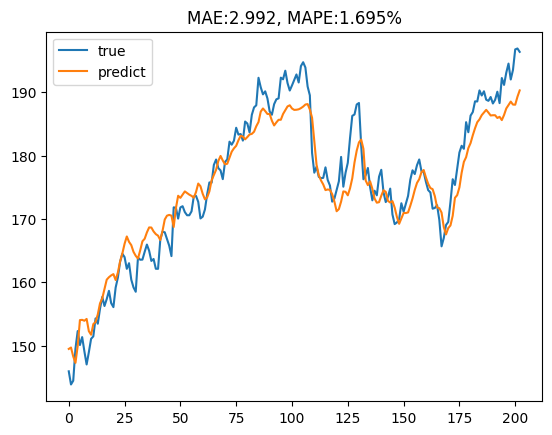

In [11]:
# model = torch.load("model.pt")
# len(test_set)
close_price_pred = []
model = torch.load('gru_10.pth')
model.to(device)
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device))
    pred = pred.detach().cpu().numpy()[0]
    pred = pred.reshape(-1, 1)
    # print(pred)
    pred = np.repeat(pred, 4, axis=1)
    pred_inver = scaler.inverse_transform(pred)
    # print(pred_inver[0][0])
    close_price_pred.append(pred_inver[0][0])
print(close_price_pred)
mape = np.mean(np.absolute(np.array(close_price_true) - np.array(close_price_pred))/np.array(close_price_true))
mae =  np.mean( np.absolute(np.array(close_price_true) - np.array(close_price_pred)))
plt.plot(close_price_true)
plt.plot(close_price_pred)
plt.title('MAE:{:.3f}, MAPE:{:.3f}%'.format(mae, mape*100))
plt.legend(['true', 'predict'])

In [12]:
def preprocess(data_trend, train_ratio, n_past, predict_day):     
    train_ind = int(len(data_trend) * train_ratio)
    train_data = data_trend[:train_ind]
    test_data = data_trend[train_ind:]

    # 產生序列資料
    X_train_full, Y_train_full = create_sequences(train_data, n_past, predict_day)
    X_test, Y_test = create_sequences(test_data, n_past, predict_day)

    val_ind = int(len(X_train_full) * test_val_ratio)
    X_train, X_val = X_train_full[:val_ind], X_train_full[val_ind:]
    Y_train, Y_val = Y_train_full[:val_ind], Y_train_full[val_ind:]

    return X_train, Y_train, X_val, Y_val, X_test, Y_test



def create_sequences(data, n_past, predict_day):
    X, Y = [], []
    L = len(data)
    for i in range(L - (n_past + predict_day - 1)):
        X.append(data[i:i + n_past])  # 過去 n_past 天的資料
        Y.append(data[i + n_past:i + n_past + predict_day, 0])  # 預測未來 predict_day 天的目標變數
    return torch.Tensor(np.array(X)), torch.Tensor(np.array(Y))

data2 = df[[c for c in df.columns if c not in ['Date','Volume']]].values
X_train, Y_train, X_val, Y_val, X_test, Y_test = preprocess(data2, train_ratio, n_past, predict_day)
Y_test.shape

torch.Size([203, 10])

In [13]:
print(Y_test.shape)
pred_arr = []
#len(test_set)
arr = []
for i in range(len(test_set)):
    x,y = test_set[i]
    x = torch.unsqueeze(x,0)
    y = torch.unsqueeze(y,0)
    pred = model(x.to(device))
    pred = pred.detach().cpu().numpy()
    pred = pred.reshape(-1, 1)
    pred = np.repeat(pred, 4, axis=1)
    # print(pred)
    pred_inver = scaler.inverse_transform(pred)
    # print(pred_inver[:, 3])
    pred_arr.append(pred_inver[:, 0])
pred_arr = np.array(pred_arr)
pred_arr = torch.tensor(pred_arr)


torch.Size([203, 10])


In [14]:
print(pred_arr.shape)
mae = torch.mean(torch.abs(pred_arr - Y_test))
mape = torch.mean(torch.abs(pred_arr - Y_test)/Y_test)
print(f"mae: {mae.item()}")
print(f"mape: {mape.item()*100}%")

torch.Size([203, 10])
mae: 4.563146591186523
mape: 2.596708945930004%
